# Bayesian Statistics with PyMC

This notebook introduces Bayesian inference using PyMC:

**Core Concepts**:
- **Prior**: Our beliefs before seeing data
- **Likelihood**: How probable is the data given parameters
- **Posterior**: Updated beliefs after seeing data
- **Bayes' Theorem**: $P(\theta|D) \propto P(D|\theta) \cdot P(\theta)$

**Topics Covered**:
1. Estimating a proportion (Beta-Binomial)
2. Estimating a mean (Normal model)
3. Bayesian Linear Regression
4. Model comparison
5. Prior sensitivity analysis

**Why Bayesian?**
- Quantify uncertainty in parameters (not just point estimates)
- Incorporate prior knowledge
- Natural interpretation of probability
- Works well with small samples

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy import stats

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
az.style.use('arviz-darkgrid')
np.random.seed(42)

print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")

PyMC version: 5.27.1
ArviZ version: 0.23.4


---
## 1. The Bayesian Framework

**Frequentist**: Parameters are fixed, data varies. Probability = long-run frequency.

**Bayesian**: Parameters have distributions. Probability = degree of belief.

**Bayes' Theorem**:
$$P(\theta | D) = \frac{P(D | \theta) \cdot P(\theta)}{P(D)}$$

- $P(\theta)$: **Prior** - What we believe before data
- $P(D|\theta)$: **Likelihood** - Probability of data given parameters
- $P(\theta|D)$: **Posterior** - Updated belief after data
- $P(D)$: **Evidence** - Normalizing constant

**In practice**: Posterior ∝ Likelihood × Prior

/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_70813/1974984797.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


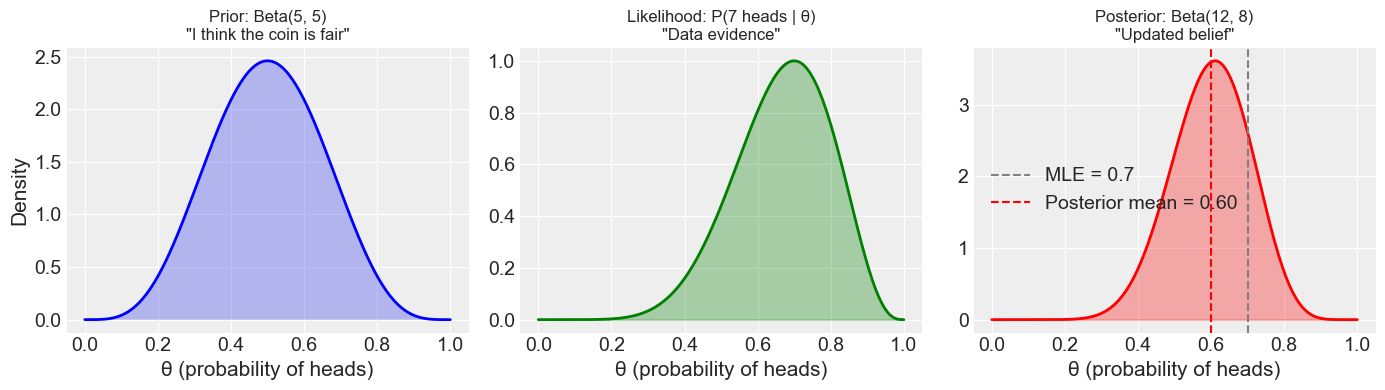

Key Insight:
  MLE (just data): 0.70
  Posterior mean (prior + data): 0.60
  → Prior 'pulls' the estimate toward 0.5


In [6]:
# Example: Visualizing Bayes' theorem for coin flipping
# Prior: We think the coin is fair (peak at 0.5)
# Data: We observe 7 heads in 10 flips

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
theta = np.linspace(0, 1, 200)

# Prior: Beta(5, 5) - centered at 0.5
prior = stats.beta(5, 5)
axes[0].plot(theta, prior.pdf(theta), 'b-', linewidth=2)
axes[0].fill_between(theta, prior.pdf(theta), alpha=0.3)
axes[0].set_title('Prior: Beta(5, 5)\n"I think the coin is fair"', fontsize=12)
axes[0].set_xlabel('θ (probability of heads)')
axes[0].set_ylabel('Density')

# Likelihood: Binomial(10, θ) with 7 successes
likelihood = stats.binom(10, theta).pmf(7)
likelihood_normalized = likelihood / likelihood.max()  # Normalize for visualization
axes[1].plot(theta, likelihood_normalized, 'g-', linewidth=2)
axes[1].fill_between(theta, likelihood_normalized, alpha=0.3, color='green')
axes[1].set_title('Likelihood: P(7 heads | θ)\n"Data evidence"', fontsize=12)
axes[1].set_xlabel('θ (probability of heads)')

# Posterior: Beta(5+7, 5+3) = Beta(12, 8)
posterior = stats.beta(12, 8)
axes[2].plot(theta, posterior.pdf(theta), 'r-', linewidth=2)
axes[2].fill_between(theta, posterior.pdf(theta), alpha=0.3, color='red')
axes[2].axvline(7/10, color='gray', linestyle='--', label='MLE = 0.7')
axes[2].axvline(posterior.mean(), color='red', linestyle='--', label=f'Posterior mean = {posterior.mean():.2f}')
axes[2].set_title('Posterior: Beta(12, 8)\n"Updated belief"', fontsize=12)
axes[2].set_xlabel('θ (probability of heads)')
axes[2].legend()

plt.tight_layout()
plt.show()

print("Key Insight:")
print(f"  MLE (just data): {7/10:.2f}")
print(f"  Posterior mean (prior + data): {posterior.mean():.2f}")
print("  → Prior 'pulls' the estimate toward 0.5")

---
## 2. First PyMC Model: Estimating a Proportion

**Problem**: A clinical trial tests a new treatment. Of 50 patients, 35 respond positively. What is the true response rate?

**Model**:
- Prior: $\theta \sim \text{Beta}(1, 1)$ (uniform, no prior knowledge)
- Likelihood: $y \sim \text{Binomial}(n, \theta)$

**PyMC workflow**:
1. Define model with `pm.Model()`
2. Specify priors and likelihood
3. Sample from posterior with MCMC
4. Analyze results

In [7]:
# Example: Estimating treatment response rate
# Data
n_patients = 50
n_responders = 35

# Build PyMC model
with pm.Model() as response_model:
    # Prior: Uniform (no prior knowledge)
    theta = pm.Beta('theta', alpha=1, beta=1)
    
    # Likelihood: Binomial
    y = pm.Binomial('y', n=n_patients, p=theta, observed=n_responders)
    
    # Sample from posterior
    trace = pm.sample(2000, tune=1000, cores=2, random_seed=42, 
                      return_inferencedata=True, progressbar=True)

print("\nSampling complete!")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Sampling complete!


Posterior Summary:
        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta  0.692  0.063     0.574      0.817      0.002    0.001    1647.0   

       ess_tail  r_hat  
theta    2274.0    1.0  


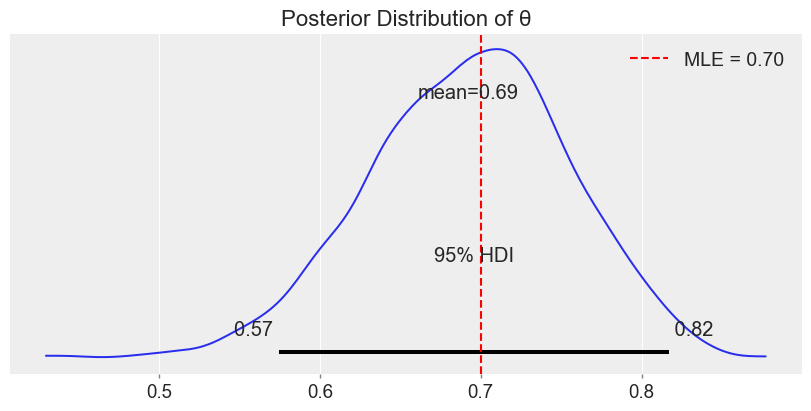

/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_70813/2444810553.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


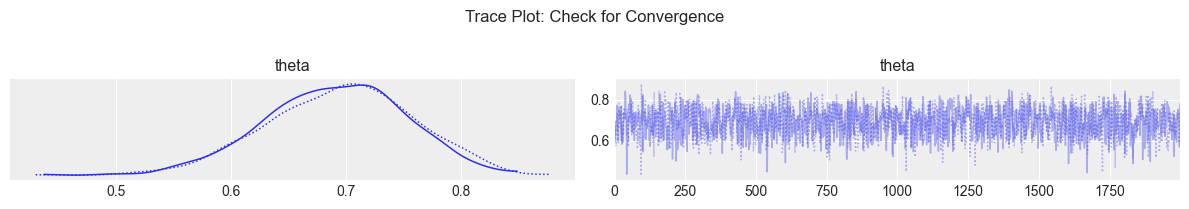

In [8]:
# Analyze results
print("Posterior Summary:")
print("="*60)
summary = az.summary(trace, var_names=['theta'], hdi_prob=0.95)
print(summary)

# Visualize posterior distribution
az.plot_posterior(trace, var_names=['theta'], 
                  point_estimate='mean', hdi_prob=0.95, figsize=(8, 4))
plt.axvline(n_responders/n_patients, color='red', linestyle='--', 
            label=f'MLE = {n_responders/n_patients:.2f}')
plt.legend()
plt.title('Posterior Distribution of θ')
plt.show()

# Trace plot (check convergence)
az.plot_trace(trace, var_names=['theta'])
plt.suptitle('Trace Plot: Check for Convergence', y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# Probability statements (the power of Bayesian!)
posterior_samples = trace.posterior['theta'].values.flatten()

print("Probability Statements:")
print("="*60)
print(f"P(θ > 0.5) = {(posterior_samples > 0.5).mean():.3f}")
print(f"  → {(posterior_samples > 0.5).mean()*100:.1f}% probability treatment is better than chance")
print()
print(f"P(θ > 0.6) = {(posterior_samples > 0.6).mean():.3f}")
print(f"P(0.6 < θ < 0.8) = {((posterior_samples > 0.6) & (posterior_samples < 0.8)).mean():.3f}")
print()
print("95% Credible Interval:")
hdi = az.hdi(trace, var_names=['theta'], hdi_prob=0.95)
print(f"  [{hdi['theta'].values[0]:.3f}, {hdi['theta'].values[1]:.3f}]")
print("  → We are 95% certain the true response rate is in this interval")

Probability Statements:
P(θ > 0.5) = 0.997
  → 99.7% probability treatment is better than chance

P(θ > 0.6) = 0.921
P(0.6 < θ < 0.8) = 0.884

95% Credible Interval:
  [0.574, 0.817]
  → We are 95% certain the true response rate is in this interval


### Exercise 1: Estimating a Proportion

A survey asks 200 people if they support a policy. 124 say yes.

**1.1** Build a PyMC model with `Beta(1, 1)` prior to estimate the true support rate.

**1.2** Report the posterior mean and 95% HDI (Highest Density Interval).

**1.3** What is P(support > 0.5)? Is there strong evidence the policy is popular?

In [10]:
# Exercise 1: YOUR CODE HERE

---
## 3. Estimating a Mean: Normal Model

**Problem**: Estimate the average height of a population from a sample.

**Model**:
- Prior on mean: $\mu \sim \text{Normal}(170, 20)$
- Prior on std: $\sigma \sim \text{HalfNormal}(10)$
- Likelihood: $y_i \sim \text{Normal}(\mu, \sigma)$

In [11]:
# Example: Estimating mean height
# Simulated data: heights in cm
np.random.seed(42)
true_mu = 175
true_sigma = 8
heights = np.random.normal(true_mu, true_sigma, size=30)

print(f"Sample: n={len(heights)}, mean={heights.mean():.1f}, std={heights.std():.1f}")

# Build model
with pm.Model() as height_model:
    # Priors
    mu = pm.Normal('mu', mu=170, sigma=20)  # Prior mean centered at 170
    sigma = pm.HalfNormal('sigma', sigma=10)  # Positive only
    
    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=heights)
    
    # Sample
    trace_height = pm.sample(2000, tune=1000, cores=2, random_seed=42,
                             return_inferencedata=True)

print("\nSampling complete!")

Sample: n=30, mean=173.5, std=7.1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Sampling complete!


Posterior Summary:
          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     173.443  1.391   170.655    176.084      0.025    0.028    3056.0   
sigma    7.488  1.029     5.726      9.641      0.021    0.021    2565.0   

       ess_tail  r_hat  
mu       2318.0    1.0  
sigma    2486.0    1.0  

True values: μ=175, σ=8


/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_70813/1726243597.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


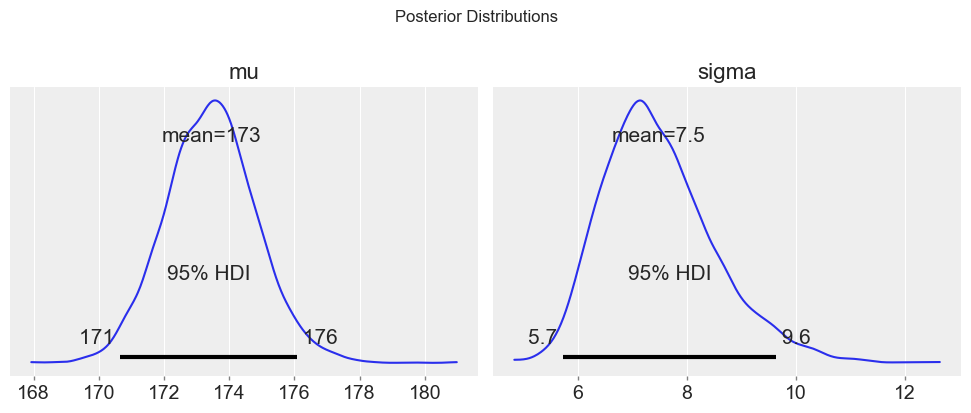

/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_70813/1726243597.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_70813/1726243597.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


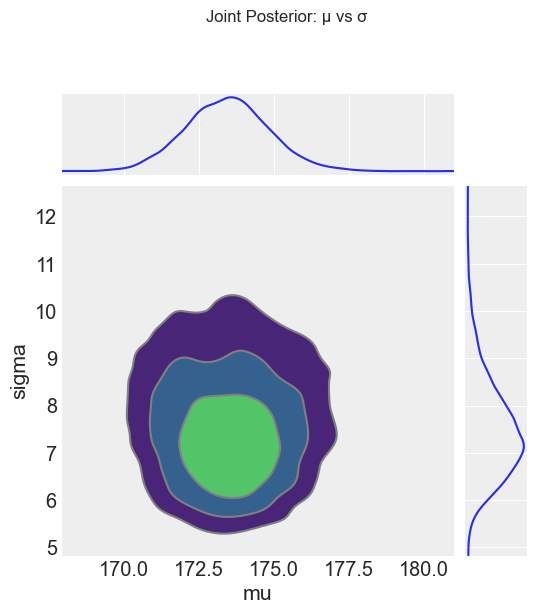

In [12]:
# Results
print("Posterior Summary:")
print("="*60)
print(az.summary(trace_height, var_names=['mu', 'sigma'], hdi_prob=0.95))

print(f"\nTrue values: μ={true_mu}, σ={true_sigma}")

# Visualize
az.plot_posterior(trace_height, var_names=['mu', 'sigma'], 
                  point_estimate='mean', hdi_prob=0.95,
                  figsize=(10, 4))
plt.suptitle('Posterior Distributions', y=1.02)
plt.tight_layout()
plt.show()

# Joint posterior
az.plot_pair(trace_height, var_names=['mu', 'sigma'], 
             kind='kde', marginals=True, figsize=(6, 6))
plt.suptitle('Joint Posterior: μ vs σ', y=1.02)
plt.tight_layout()
plt.show()

### Exercise 2: Estimating a Mean

You measure the reaction time (in ms) of 25 participants:

```python
reaction_times = np.array([245, 312, 278, 289, 301, 256, 267, 298, 284, 276,
                           290, 305, 271, 288, 294, 262, 279, 296, 285, 273,
                           291, 268, 282, 299, 275])
```

**2.1** Build a Normal model with priors: `mu ~ Normal(300, 50)` and `sigma ~ HalfNormal(50)`.

**2.2** Report posterior summaries for μ and σ.

**2.3** What is P(μ < 290)? Are reaction times significantly faster than 290ms?

In [13]:
# Exercise 2: YOUR CODE HERE
reaction_times = np.array([245, 312, 278, 289, 301, 256, 267, 298, 284, 276,
                           290, 305, 271, 288, 294, 262, 279, 296, 285, 273,
                           291, 268, 282, 299, 275])

---
## 4. Bayesian Linear Regression

**Model**: $y = \alpha + \beta x + \epsilon$, where $\epsilon \sim N(0, \sigma)$

**Bayesian approach**:
- Put priors on $\alpha$, $\beta$, and $\sigma$
- Get full posterior distributions for all parameters
- Uncertainty in predictions (not just point estimates)

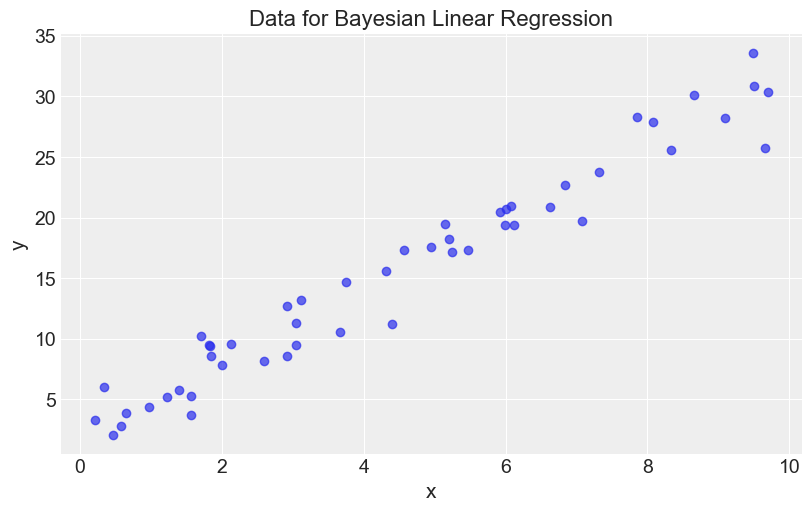

True parameters: α=2, β=3, σ=2


In [14]:
# Example: Bayesian Linear Regression
# Generate data: y = 2 + 3x + noise
np.random.seed(42)
n = 50
x = np.random.uniform(0, 10, n)
true_alpha = 2
true_beta = 3
true_sigma = 2
y = true_alpha + true_beta * x + np.random.normal(0, true_sigma, n)

# Visualize
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data for Bayesian Linear Regression')
plt.show()

print(f"True parameters: α={true_alpha}, β={true_beta}, σ={true_sigma}")

In [15]:
# Build Bayesian Linear Regression model
with pm.Model() as linear_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=5)
    
    # Expected value
    mu = alpha + beta * x
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    # Sample
    trace_linear = pm.sample(2000, tune=1000, cores=2, random_seed=42,
                             return_inferencedata=True)

print("\nSampling complete!")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Sampling complete!


In [16]:
# Results
print("Posterior Summary:")
print("="*60)
print(az.summary(trace_linear, var_names=['alpha', 'beta', 'sigma'], hdi_prob=0.95))

print(f"\nTrue values: α={true_alpha}, β={true_beta}, σ={true_sigma}")

Posterior Summary:
        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  2.197  0.500     1.223      3.163      0.012    0.009    1761.0   
beta   2.954  0.094     2.771      3.142      0.002    0.002    1787.0   
sigma  1.903  0.201     1.531      2.301      0.004    0.004    2550.0   

       ess_tail  r_hat  
alpha    1862.0    1.0  
beta     1700.0    1.0  
sigma    2402.0    1.0  

True values: α=2, β=3, σ=2


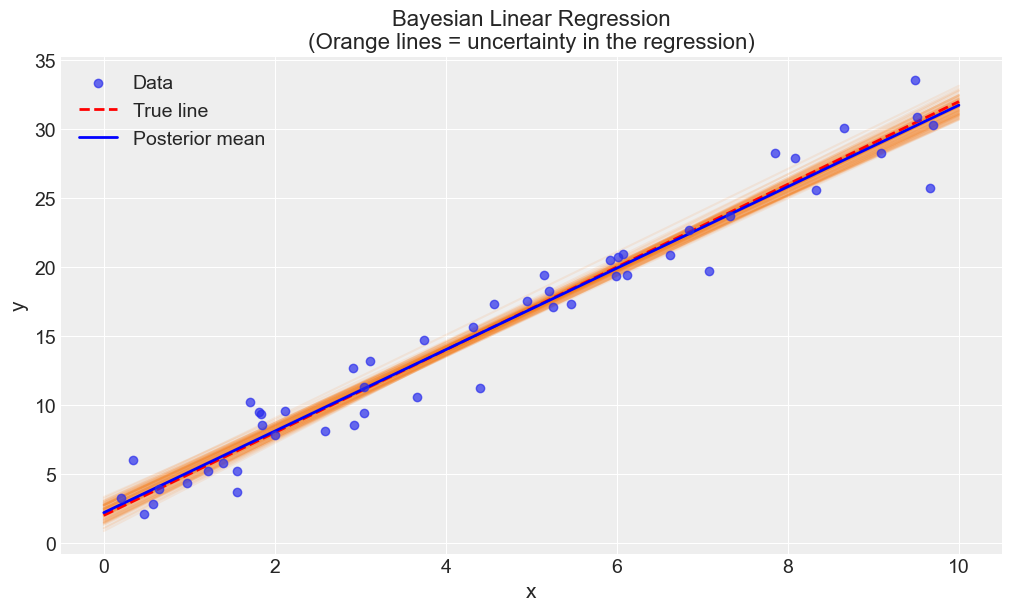

In [17]:
# Visualize: Posterior predictive regression lines
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data
ax.scatter(x, y, alpha=0.7, label='Data', zorder=5)

# Plot posterior regression lines (sample 100)
alpha_samples = trace_linear.posterior['alpha'].values.flatten()[:100]
beta_samples = trace_linear.posterior['beta'].values.flatten()[:100]

x_plot = np.linspace(0, 10, 100)
for a, b in zip(alpha_samples, beta_samples):
    ax.plot(x_plot, a + b * x_plot, 'C1', alpha=0.1)

# True line
ax.plot(x_plot, true_alpha + true_beta * x_plot, 'r--', linewidth=2, label='True line')

# Posterior mean line
mean_alpha = trace_linear.posterior['alpha'].values.mean()
mean_beta = trace_linear.posterior['beta'].values.mean()
ax.plot(x_plot, mean_alpha + mean_beta * x_plot, 'b-', linewidth=2, label='Posterior mean')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Bayesian Linear Regression\n(Orange lines = uncertainty in the regression)')
ax.legend()
plt.show()

### Exercise 3: Bayesian Linear Regression

Load the tips dataset and model `tip` as a function of `total_bill`.

**3.1** Build a Bayesian linear regression: `tip ~ α + β * total_bill + ε`

**3.2** Report posterior summaries for α, β, and σ.

**3.3** What is P(β > 0)? Is there strong evidence of a positive relationship?

**3.4** Plot the posterior regression lines with uncertainty.

In [18]:
# Exercise 3: YOUR CODE HERE
tips = sns.load_dataset('tips')

---
## 5. Comparing Groups: Bayesian t-test

**Problem**: Compare two groups (e.g., treatment vs control).

**Bayesian approach**:
- Model each group with its own mean
- Compute posterior of the difference
- P(μ₁ > μ₂) directly answers "Is group 1 better?"

In [19]:
# Example: Comparing two groups
np.random.seed(42)

# Simulated data: treatment effect
control = np.random.normal(100, 15, 30)
treatment = np.random.normal(110, 15, 30)  # True effect = 10

print(f"Control: mean={control.mean():.1f}, std={control.std():.1f}")
print(f"Treatment: mean={treatment.mean():.1f}, std={treatment.std():.1f}")
print(f"Sample difference: {treatment.mean() - control.mean():.1f}")

Control: mean=97.2, std=13.3
Treatment: mean=108.2, std=13.7
Sample difference: 11.0


In [20]:
# Bayesian comparison
with pm.Model() as comparison_model:
    # Priors for control group
    mu_control = pm.Normal('mu_control', mu=100, sigma=20)
    
    # Priors for treatment group
    mu_treatment = pm.Normal('mu_treatment', mu=100, sigma=20)
    
    # Shared sigma (assume equal variance)
    sigma = pm.HalfNormal('sigma', sigma=20)
    
    # Difference (derived quantity)
    diff = pm.Deterministic('difference', mu_treatment - mu_control)
    
    # Likelihoods
    y_control = pm.Normal('y_control', mu=mu_control, sigma=sigma, observed=control)
    y_treatment = pm.Normal('y_treatment', mu=mu_treatment, sigma=sigma, observed=treatment)
    
    # Sample
    trace_comparison = pm.sample(2000, tune=1000, cores=2, random_seed=42,
                                  return_inferencedata=True)

print("\nSampling complete!")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_control, mu_treatment, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Sampling complete!


Posterior Summary:
                 mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
mu_control     97.270  2.535    92.450    102.385      0.033    0.038   
mu_treatment  108.093  2.593   102.905    113.173      0.035    0.046   
difference     10.823  3.641     3.899     18.236      0.048    0.055   

              ess_bulk  ess_tail  r_hat  
mu_control      5979.0    3609.0    1.0  
mu_treatment    5688.0    2839.0    1.0  
difference      5687.0    3150.0    1.0  


/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_70813/546197760.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


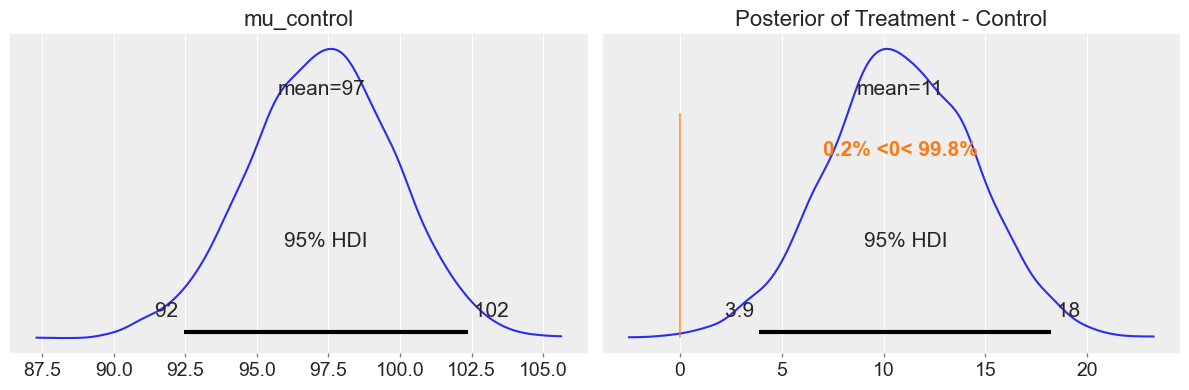


P(treatment > control) = 0.998
P(difference > 5) = 0.944
P(difference > 10) = 0.587


In [21]:
# Results
print("Posterior Summary:")
print("="*60)
print(az.summary(trace_comparison, var_names=['mu_control', 'mu_treatment', 'difference'], 
                 hdi_prob=0.95))

# Posterior of difference
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Both group means
az.plot_posterior(trace_comparison, var_names=['mu_control', 'mu_treatment'], ax=axes[0],
                  point_estimate='mean', hdi_prob=0.95)

# The difference
az.plot_posterior(trace_comparison, var_names=['difference'], ax=axes[1],
                  point_estimate='mean', hdi_prob=0.95, ref_val=0)
axes[1].set_title('Posterior of Treatment - Control')

plt.tight_layout()
plt.show()

# Probability statements
diff_samples = trace_comparison.posterior['difference'].values.flatten()
print(f"\nP(treatment > control) = {(diff_samples > 0).mean():.3f}")
print(f"P(difference > 5) = {(diff_samples > 5).mean():.3f}")
print(f"P(difference > 10) = {(diff_samples > 10).mean():.3f}")

### Exercise 4: Comparing Groups

Use the tips dataset to compare total bills between smokers and non-smokers.

**4.1** Build a Bayesian model to compare mean `total_bill` between smokers vs non-smokers.

**4.2** Report posterior summaries for both means and their difference.

**4.3** What is P(smokers spend more)? Is there a meaningful difference?

In [22]:
# Exercise 4: YOUR CODE HERE

---
## 6. Prior Sensitivity Analysis

**Key Question**: How much do our results depend on the prior?

**Good practice**: Try different priors and check if conclusions change.
- If results are similar → robust conclusions
- If results differ → data is not very informative, prior matters

/var/folders/t9/0pk458_94qv27021t99vs5fr0000gn/T/ipykernel_70813/1266889073.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


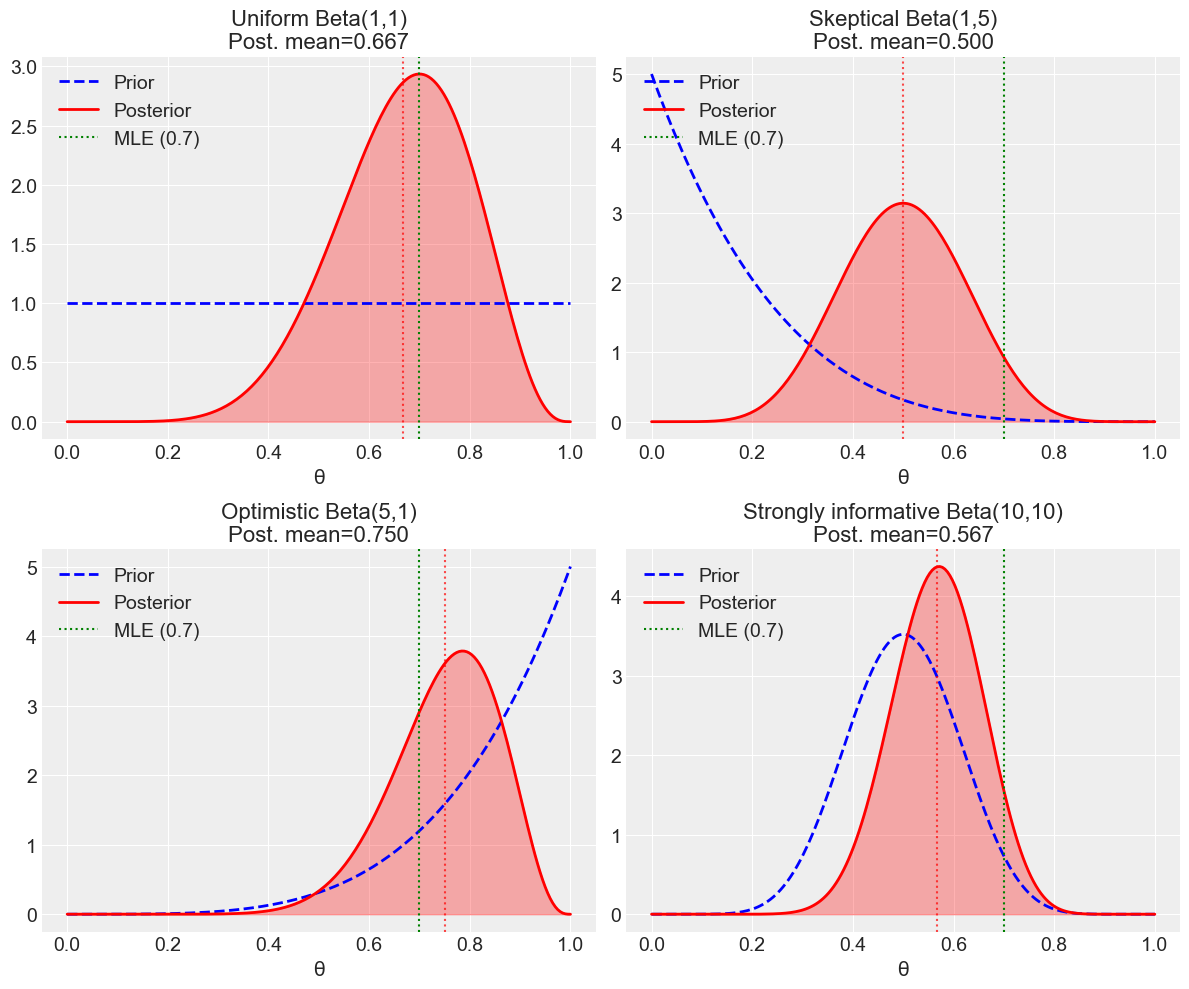


Sensitivity Analysis Results:
Uniform Beta(1,1)                  : mean=0.667, std=0.131
Skeptical Beta(1,5)                : mean=0.500, std=0.121
Optimistic Beta(5,1)               : mean=0.750, std=0.105
Strongly informative Beta(10,10)   : mean=0.567, std=0.089

Conclusion:
  With only 10 data points, the prior has noticeable influence.
  With more data, all posteriors would converge.


In [23]:
# Example: Prior sensitivity for proportion estimation
# Data: 7 successes in 10 trials (same as before)
n_trials = 10
n_success = 7

# Try different priors
priors = {
    'Uniform Beta(1,1)': (1, 1),
    'Skeptical Beta(1,5)': (1, 5),    # Prior belief: success is unlikely
    'Optimistic Beta(5,1)': (5, 1),   # Prior belief: success is likely
    'Strongly informative Beta(10,10)': (10, 10)  # Strong belief: p ≈ 0.5
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
theta = np.linspace(0, 1, 200)

results = {}

for idx, (name, (a, b)) in enumerate(priors.items()):
    ax = axes[idx]
    
    # Prior
    prior = stats.beta(a, b)
    ax.plot(theta, prior.pdf(theta), 'b--', label='Prior', linewidth=2)
    
    # Posterior: Beta(a + success, b + failures)
    posterior = stats.beta(a + n_success, b + (n_trials - n_success))
    ax.plot(theta, posterior.pdf(theta), 'r-', label='Posterior', linewidth=2)
    ax.fill_between(theta, posterior.pdf(theta), alpha=0.3, color='red')
    
    # Stats
    post_mean = posterior.mean()
    post_std = posterior.std()
    results[name] = {'mean': post_mean, 'std': post_std}
    
    ax.axvline(0.7, color='green', linestyle=':', label='MLE (0.7)')
    ax.axvline(post_mean, color='red', linestyle=':', alpha=0.7)
    
    ax.set_title(f'{name}\nPost. mean={post_mean:.3f}')
    ax.set_xlabel('θ')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("\nSensitivity Analysis Results:")
print("="*50)
for name, res in results.items():
    print(f"{name:35s}: mean={res['mean']:.3f}, std={res['std']:.3f}")

print("\nConclusion:")
print("  With only 10 data points, the prior has noticeable influence.")
print("  With more data, all posteriors would converge.")

### Exercise 5: Prior Sensitivity

Return to Exercise 1 (policy support: 124/200).

**5.1** Re-run the analysis with three different priors:
   - Uniform: `Beta(1, 1)`
   - Skeptical: `Beta(2, 10)` (prior belief: support is low)
   - Optimistic: `Beta(10, 2)` (prior belief: support is high)

**5.2** Compare the posterior means and 95% HDIs.

**5.3** How much do the priors affect the conclusions? Why?

In [24]:
# Exercise 5: YOUR CODE HERE

---
## 7. Posterior Predictive Checks

**Key Question**: Does our model generate data that looks like the real data?

**Process**:
1. Draw parameters from the posterior
2. Generate simulated data using those parameters
3. Compare simulated data to observed data

Sampling: [y]


Output()

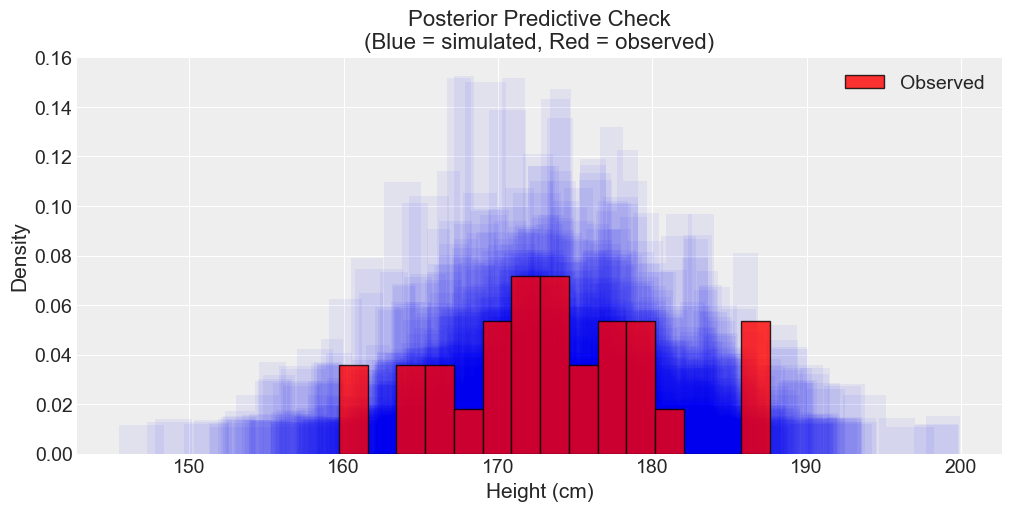

If the observed data (red) falls within the range of simulated data (blue),
the model is capturing the data-generating process well.


In [25]:
# Example: Posterior predictive check for height model
with height_model:
    ppc = pm.sample_posterior_predictive(trace_height, random_seed=42)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Simulated data from posterior
y_ppc = ppc.posterior_predictive['y'].values.reshape(-1, len(heights))

# Plot some simulated datasets
for i in range(100):
    ax.hist(y_ppc[i], bins=15, alpha=0.05, color='blue', density=True)

# Observed data
ax.hist(heights, bins=15, alpha=0.8, color='red', density=True, 
        edgecolor='black', label='Observed')

ax.set_xlabel('Height (cm)')
ax.set_ylabel('Density')
ax.set_title('Posterior Predictive Check\n(Blue = simulated, Red = observed)')
ax.legend()
plt.show()

print("If the observed data (red) falls within the range of simulated data (blue),")
print("the model is capturing the data-generating process well.")

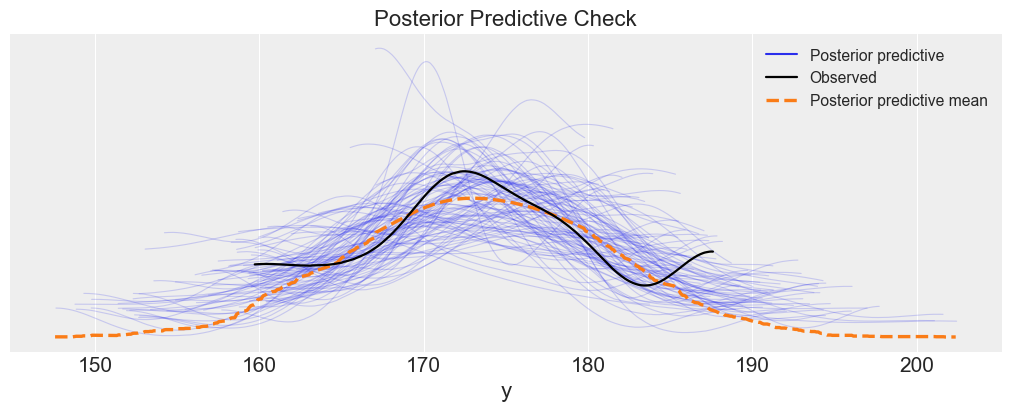

In [26]:
# ArviZ has nice built-in PPC plots
# Extend the trace with the posterior predictive samples
trace_with_ppc = trace_height.copy()
trace_with_ppc.extend(ppc)
az.plot_ppc(trace_with_ppc, num_pp_samples=100, figsize=(10, 4))
plt.title('Posterior Predictive Check')
plt.show()

---
## Key Takeaways

In [27]:
print("KEY TAKEAWAYS")
print("="*70)
print()
print("1. BAYESIAN FRAMEWORK:")
print("   Posterior ∝ Likelihood × Prior")
print("   • Prior: what we believe before seeing data")
print("   • Likelihood: how probable is the data given parameters")
print("   • Posterior: updated beliefs after seeing data")
print()
print("2. ADVANTAGES OF BAYESIAN:")
print("   • Full uncertainty quantification (distributions, not points)")
print("   • Direct probability statements: P(θ > 0.5)")
print("   • Natural interpretation: 'There is 95% probability that...'")
print("   • Incorporate prior knowledge formally")
print()
print("3. PyMC WORKFLOW:")
print("   1. Define model: pm.Model()")
print("   2. Specify priors: pm.Normal(), pm.Beta(), etc.")
print("   3. Define likelihood: link data to parameters")
print("   4. Sample: pm.sample()")
print("   5. Analyze: az.summary(), az.plot_posterior()")
print()
print("4. MODEL CHECKING:")
print("   • Trace plots: check convergence")
print("   • Prior sensitivity: does the prior matter?")
print("   • Posterior predictive: does the model fit the data?")
print()
print("5. INTERPRETATION:")
print("   • HDI (Highest Density Interval): 95% HDI = 95% probability region")
print("   • P(θ > x): direct probability of hypothesis")
print("   • Posterior mean: point estimate with uncertainty")

KEY TAKEAWAYS

1. BAYESIAN FRAMEWORK:
   Posterior ∝ Likelihood × Prior
   • Prior: what we believe before seeing data
   • Likelihood: how probable is the data given parameters
   • Posterior: updated beliefs after seeing data

2. ADVANTAGES OF BAYESIAN:
   • Full uncertainty quantification (distributions, not points)
   • Direct probability statements: P(θ > 0.5)
   • Natural interpretation: 'There is 95% probability that...'
   • Incorporate prior knowledge formally

3. PyMC WORKFLOW:
   1. Define model: pm.Model()
   2. Specify priors: pm.Normal(), pm.Beta(), etc.
   3. Define likelihood: link data to parameters
   4. Sample: pm.sample()
   5. Analyze: az.summary(), az.plot_posterior()

4. MODEL CHECKING:
   • Trace plots: check convergence
   • Prior sensitivity: does the prior matter?
   • Posterior predictive: does the model fit the data?

5. INTERPRETATION:
   • HDI (Highest Density Interval): 95% HDI = 95% probability region
   • P(θ > x): direct probability of hypothesis
   •